In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os

In [2]:
"""
Implementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.

Multiple optimizers are used and compared.
"""

'\nImplementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.\n\nMultiple optimizers are used and compared.\n'

In [3]:
# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

In [4]:
# Define the dihydrogen Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# 1 spatial orbital for each H
# Each spatial orbital is doubly-degenerate (2 spin orbitals)
print(f"{qubits} qubits required")

4 qubits required


In [5]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 2  # 1 from each H
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Show that the first 2 orbitals are occupied
# Print the state in bra-ket notation
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |1100⟩


In [6]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-0.88842304, requires_grad=True)

In [7]:
# Generate excitation indices
singles, doubles = excitations(electrons, qubits)
print(f"Singles Excitations: {singles}")  # e.g: [0, 1] is a single excitation of an electron in orbital 0 to orbital 1
print(f"Doubles Excitations: {doubles}")  # e.g: [0, 1, 2, 3] is a double excitation of electrons in orbitals 0 and 1 to orbitals 2 and 3


# Define an ansatz using the excitations
def ansatz(params_singles, params_doubles):
    # Initialize the qubit register in the Hartree-Fock state
    qml.BasisState(hf, wires=range(num_wires))
    
    # Apply single excitations
    for i, excitation in enumerate(singles):
        qml.SingleExcitation(params_singles[i], wires=excitation)
    
    # Apply double excitations
    for i, excitation in enumerate(doubles):
        qml.DoubleExcitation(params_doubles[i], wires=excitation)

Singles Excitations: [[0, 2], [1, 3]]
Doubles Excitations: [[0, 1, 2, 3]]


In [8]:
# Define the VQE cost function
@qml.qnode(dev)
def cost_function(params_singles, params_doubles):
    ansatz(params_singles, params_doubles)

    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

# Initialize both parameter sets to zero-vectors
initial_params_singles = np.zeros(len(singles), requires_grad=True)
initial_params_doubles = np.zeros(len(doubles), requires_grad=True)

# Confirm the initial energy of the system using the Hartree-Fock state
# This is the starting point for classical optimization
cost_function(initial_params_singles, initial_params_doubles)

tensor(-0.88842304, requires_grad=True)

In [13]:
def run_vqe(optimizer_class, stepsize=0.1, max_iterations=50):
    theta_singles = np.zeros(len(singles), requires_grad=True)
    theta_doubles = np.zeros(len(doubles), requires_grad=True)

    opt = optimizer_class(stepsize)
    energy = [cost_function(theta_singles, theta_doubles)]

    for _ in range(max_iterations):
        (theta_singles, theta_doubles), _ = opt.step_and_cost(
            cost_function, theta_singles, theta_doubles
        )
        energy.append(cost_function(theta_singles, theta_doubles))

    return {
        "energy": energy,
        "theta_singles": theta_singles,
        "theta_doubles": theta_doubles
    }


optimizers = {
    "Adam": (qml.AdamOptimizer, 0.2),
    "GradientDescent": (qml.GradientDescentOptimizer, 0.2),
    "Nesterov": (qml.NesterovMomentumOptimizer, 0.2),
    "Adagrad": (qml.AdagradOptimizer, 0.2),
    # "RMSProp": (qml.RMSPropOptimizer, 0.2),
    "Momentum": (qml.MomentumOptimizer, 0.2),
    "SPSA": (qml.SPSAOptimizer, 0.2),
    # "LBFGS": (qml.optimize.ScipyOptimizer, {"method": "L-BFGS-B"}),
    # "COBYLA": (qml.optimize.ScipyOptimizer, {"method": "COBYLA"}),
}

results = {}

for name, (opt_class, lr) in optimizers.items():
    print(f"Running VQE with {name}...")
    results[name] = run_vqe(opt_class, stepsize=lr, max_iterations=50)

Running VQE with Adam...
Running VQE with GradientDescent...
Running VQE with Nesterov...
Running VQE with Adagrad...
Running VQE with Momentum...
Running VQE with SPSA...


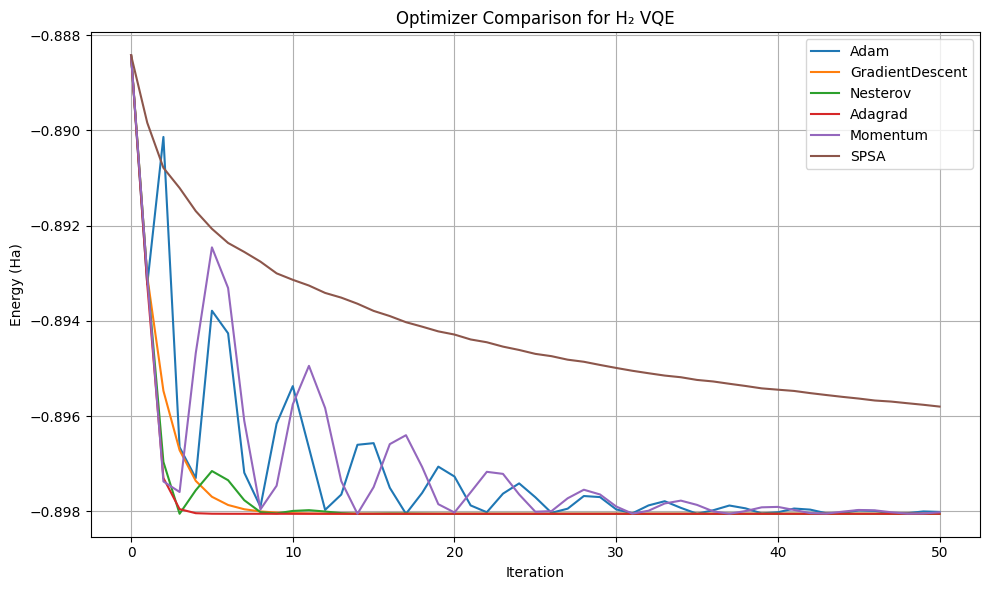

In [14]:
# Plot comparison of all optimizer energy curves
plt.figure(figsize=(10, 6))

for name, res in results.items():
    energies = res["energy"]
    plt.plot(range(len(energies)), energies, label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Optimizer Comparison for H₂ VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()

os.makedirs("images", exist_ok=True)
plt.savefig("images/H2_optimiser_comparison.png")
plt.show()

In [15]:
for name, res in results.items():
    final_energy = res["energy"][-1]
    print(f"{name}:\nFinal ground state energy = {final_energy:.8f} Ha\n")

Adam:
Final ground state energy = -0.89801392 Ha

GradientDescent:
Final ground state energy = -0.89805304 Ha

Nesterov:
Final ground state energy = -0.89805304 Ha

Adagrad:
Final ground state energy = -0.89805304 Ha

Momentum:
Final ground state energy = -0.89802171 Ha

SPSA:
Final ground state energy = -0.89580136 Ha



In [16]:
# Choose optimizer with lowest final energy
best_name = min(results, key=lambda k: results[k]["energy"][-1])
print(f"Using best optimizer: {best_name}")

best_thetas_s = results[best_name]["theta_singles"]
best_thetas_d = results[best_name]["theta_doubles"]

Using best optimizer: GradientDescent


In [17]:
@qml.qnode(dev)
def ground_state(params_singles, params_doubles):
    ansatz(params_singles, params_doubles)

    # Return the entire quantum statevector
    return qml.state()

final_state = ground_state(best_thetas_s, best_thetas_d)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}>"
    
    # Format the amplitude nicely
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression and print
ket_notation = " + ".join(ket_terms)
print(f"Ground state of H₂:\n|ψ⟩ = {ket_notation}")

Ground state of H₂:
|ψ⟩ = -0.0585|0011> + 0.9983|1100>


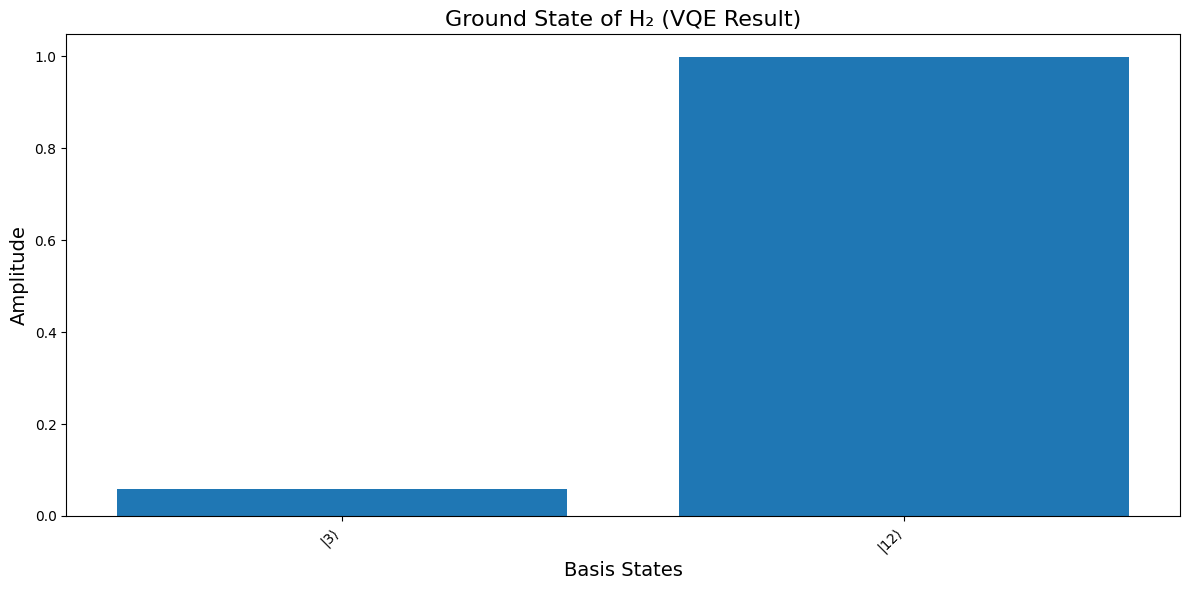

In [18]:
# Prepare labels and amplitudes for the plot
labels = [f"|{idx}⟩" for idx in non_zero_indices]  # No extra brackets

amplitudes = np.abs(non_zero_amplitudes)

# Bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of H₂ (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure to the "images" directory
plt.savefig('images/H2_ground_state.png')
plt.show()